In [1]:
import os

os.chdir(os.path.join(os.getcwd(),'..'))
os.getcwd()

'/media/user/T7 Touch/Stage_Lucas/segmentation'

In [2]:
from src.nets import UNet
from src.downloads import download_data, unzip_data
from src.datasets import UNet_Segmentation_Dataset, MaskRCNN_Segmentation_Dataset
from src.training import train_UNet, train_MaskRCNN
from src.segmentation import post_processing
from src.visualization import plot_mini_batch
from src.processing import processChallenge, normalize_images

import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split
import albumentations as alb

In [ ]:
from torchsummary import summary

MODEL = torchvision.models.segmentation.fcn_resnet101(weights='FCN_ResNet101_Weights.DEFAULT')
MODEL.backbone['conv1'] = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
MODEL.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=1)
summary(MODEL, (1,1024,1024))

In [6]:
path = '/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Warwick QU/train'

images_names = os.listdir(os.path.join(path,'images'))
masks_names = os.listdir(os.path.join(path,'masks'))

sizes = [cv2.imread(f'{path}/images/{name}', cv2.IMREAD_COLOR).shape for name in images_names]
h = [size[0] for size in sizes]
idx = np.array(h) == 522

images = np.array(images_names)[idx]
masks = np.array(masks_names)[idx]

images = np.array([os.path.join(path,'images',name) for name in images])
masks = np.array([os.path.join(path,'masks',name) for name in masks])

In [3]:
names = ['Fluo-N2DH-GOWT1', 'Fluo-C2DL-MSC', 'Warwick QU']
models = ['UNet', 'FCN', 'DeepLab', 'MaskRCNN']

NAME = names[0]
CHANNELS = 1
NORMALIZED = False
# SHAPE = (346,512) # Warwick
SHAPE = (640,640) # Gowt1
# SHAPE = (480,640) # MSC
# SHAPE = (600,600) # MSC
# SHAPE = None
TRANSFORMS = None

DATASET = UNet_Segmentation_Dataset
BATCH_SIZE = 4

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

MODEL_NAME = models[2]
if MODEL_NAME == 'UNet':
    MODEL = UNet(CHANNELS, 64, 2)
    PARAMS = MODEL.parameters()

elif MODEL_NAME == 'MaskRCNN':
    MODEL = torchvision.models.detection.maskrcnn_resnet50_fpn(weights = "MaskRCNN_ResNet50_FPN_Weights.DEFAULT")
    in_features = MODEL.roi_heads.box_predictor.cls_score.in_features
    MODEL.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
    in_features_mask = MODEL.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    MODEL.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

    PARAMS = [p for p in MODEL.parameters() if p.requires_grad]

    def custom(batch):
        imgs = [item[0] for item in batch]
        targ = [item[1] for item in batch]

        return [imgs, targ]

elif MODEL_NAME == 'FCN':
    MODEL = torchvision.models.segmentation.fcn_resnet101(weights='FCN_ResNet101_Weights.DEFAULT')
    MODEL.backbone['conv1'] = torch.nn.Conv2d(CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False)
    MODEL.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=1)
    
    PARAMS = MODEL.parameters()

elif MODEL_NAME == 'DeepLab':
    MODEL = torchvision.models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT')
    # MODEL = torchvision.models.segmentation.deeplabv3_resnet101(weights=False)
    MODEL.backbone['conv1'] = torch.nn.Conv2d(CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False)
    MODEL.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)
    # MODEL.aux_classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)

    PARAMS = MODEL.parameters()
    
else:
    print("Wrong model")

LR = 0.005
MM = 0.95
WD = 1e-4
EPOCHS = 100
STORE = 1
OPTIM = torch.optim.SGD(PARAMS, LR, MM, WD)
TRAINER = train_UNet

# processChallenge('/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/train/Fluo-N2DH-GOWT1', 'train')
# processChallenge('/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/test/Fluo-N2DH-GOWT1', 'test')

# normalize_images(f'Cell Challenge/train/{NAME}', CHANNELS)
# normalize_images(f'Cell Challenge/test/{NAME}', CHANNELS)

# img_path = "/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/train/Fluo-C2DL-MSC/02"
# mask_path = "/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/train/Fluo-C2DL-MSC/02_ST/SEG"

Train = DATASET(f'Cell Challenge/train/{NAME}', 'train', CHANNELS, NORMALIZED, SHAPE, TRANSFORMS)
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

if MODEL_NAME == 'MaskRCNN':
    train_loader = DataLoader(Cell_train, BATCH_SIZE, shuffle=True, collate_fn=custom)
    val_loader = DataLoader(Cell_val, BATCH_SIZE, shuffle=True, collate_fn=custom)

else:
    train_loader = DataLoader(Cell_train, BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(Cell_val, BATCH_SIZE, shuffle=True)

# Test = DATASET(f'Cell Challenge/test/{NAME}', 'test', CHANNELS, NORMALIZED, SHAPE, TRANSFORMS)

# test_loader = DataLoader(Test, BATCH_SIZE, shuffle=False)

cuda


In [4]:
train_loss, val_loss, _, _, dices, ious = TRAINER(MODEL, DEVICE, OPTIM, train_loader, val_loader, None, None, EPOCHS, True)

Epoch: 1/100, Train loss: 0.1902, Val loss: 1.7147, Train acc: 0.9406, Val acc: 0.1295, Dice: 0.129, IoU: 0.06897
Epoch: 2/100, Train loss: 0.0308, Val loss: 0.0577, Train acc: 0.9898, Val acc: 0.9831, Dice: 0.8695, IoU: 0.7691
Epoch: 3/100, Train loss: 0.0200, Val loss: 0.0194, Train acc: 0.9931, Val acc: 0.9933, Dice: 0.9491, IoU: 0.9032
Epoch: 4/100, Train loss: 0.0169, Val loss: 0.0172, Train acc: 0.9941, Val acc: 0.9942, Dice: 0.9567, IoU: 0.9169
Epoch: 5/100, Train loss: 0.0154, Val loss: 0.0162, Train acc: 0.9946, Val acc: 0.9945, Dice: 0.9593, IoU: 0.9218
Epoch: 6/100, Train loss: 0.0143, Val loss: 0.0153, Train acc: 0.9949, Val acc: 0.9949, Dice: 0.9615, IoU: 0.9259
Epoch: 7/100, Train loss: 0.0136, Val loss: 0.0148, Train acc: 0.9952, Val acc: 0.9950, Dice: 0.9625, IoU: 0.9277
Epoch: 8/100, Train loss: 0.0130, Val loss: 0.0143, Train acc: 0.9953, Val acc: 0.9951, Dice: 0.9634, IoU: 0.9293
Epoch: 9/100, Train loss: 0.0125, Val loss: 0.0138, Train acc: 0.9955, Val acc: 0.9953, 

KeyboardInterrupt: 

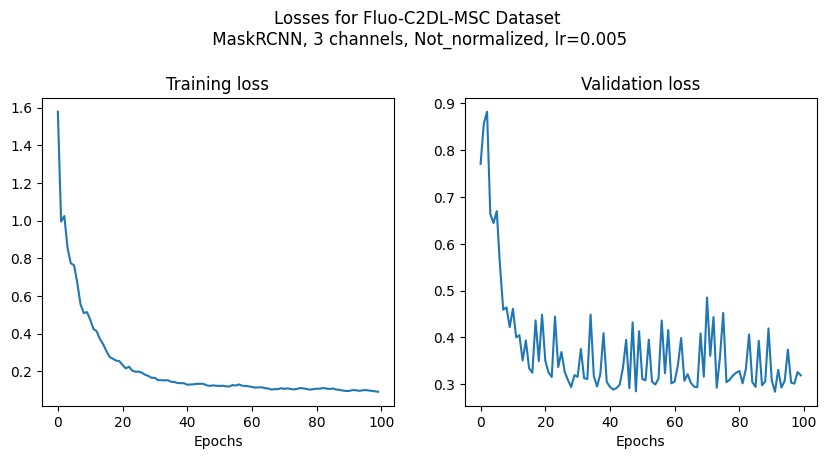

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

ax1.set_title('Training loss')
ax2.set_title('Validation loss')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

if NORMALIZED:
    NORMALIZED = 'Normalized'
else:
    NORMALIZED = 'Not_normalized'

if SHAPE == None:
    SHAPE = (782, 1200)

fig.suptitle(f'Losses for {NAME} Dataset\n {MODEL_NAME}, {CHANNELS} channels, {NORMALIZED}, lr={LR}', y=1.1);
# plt.savefig(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.png')

dic = {'train_loss': train_loss, 'val_loss': val_loss, 'dice': dices, 'IoU': ious}
df = pd.DataFrame(dic)
df.to_csv(f'experiments/{MODEL_NAME}_{NAME}_{CHANNELS}C_{NORMALIZED}_{SHAPE[0]}_{SHAPE[1]}.csv')

torch.save(MODEL.state_dict(), f'models/{MODEL_NAME}_{NAME}_{CHANNELS}C_{NORMALIZED}_{SHAPE[0]}_{SHAPE[1]}.pth')

In [9]:
Test = DATASET(f'Cell Challenge/test/{NAME}', 'test', CHANNELS, False, SHAPE, None)

test_loader = DataLoader(Test, BATCH_SIZE, shuffle=False)

In [8]:
def plot_mini_batch(imgs, masks=None, overlay=True, batch=4):
    """
    Function for representing batches from both UNet and Mask RCNN Datasets.

    Inputs:
        - imgs: original images (one for each stack at a time).
        - masks: predicted mask from one of the models.
        - overlay: boolean indicating wether to superpose images and masks in the
                   same plots or represent them separatly.
        
    Output: figure of subplots containing always 4 colums and as many rows as necce-
            sary. Depending on the value of overlay, it will create for or less rows.
            If overlay=False, there will be double number of rows and it will alternate
            between images and masks so that the mask corresponding to an images appears
            always under it.
    """

    size = imgs.shape[0]
    rows = int(np.ceil(size/batch))
    
    if overlay:
        plt.figure(figsize=(20, 10))

        for i in range(size):
            plt.subplot(rows, batch, i+1)
            plt.imshow(imgs[i])

            if masks is not None:
                plt.imshow(masks[i], alpha=0.5)

            plt.axis('Off')

    else:
        rows *= 2
        fig, ax = plt.subplots(rows, batch, figsize=(20, np.floor(5*len(imgs)/batch)))
        for i in range(size):
            group = i // batch
            off = i % batch

            ax[2*group, off].imshow(imgs[i])
            ax[2*group, off].axis('Off')
            ax[2*group+1, off].imshow(masks[i])
            ax[2*group+1, off].axis('Off')
            
    plt.tight_layout()
    plt.show()

    return

In [12]:
imgs_test = next(iter(test_loader))
imgs_test.shape

torch.Size([4, 3, 1024, 1024])

In [28]:
preds.shape

(4, 3, 1024, 1024)

[0.0000000e+00 1.8707214e-19 8.8859257e-19 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
[0.0000000e+00 3.7430349e-18 8.9658744e-18 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
[0.0000000e+00 3.9898078e-14 2.2404307e-13 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
[0.0000000e+00 3.1860111e-15 6.6906197e-14 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]


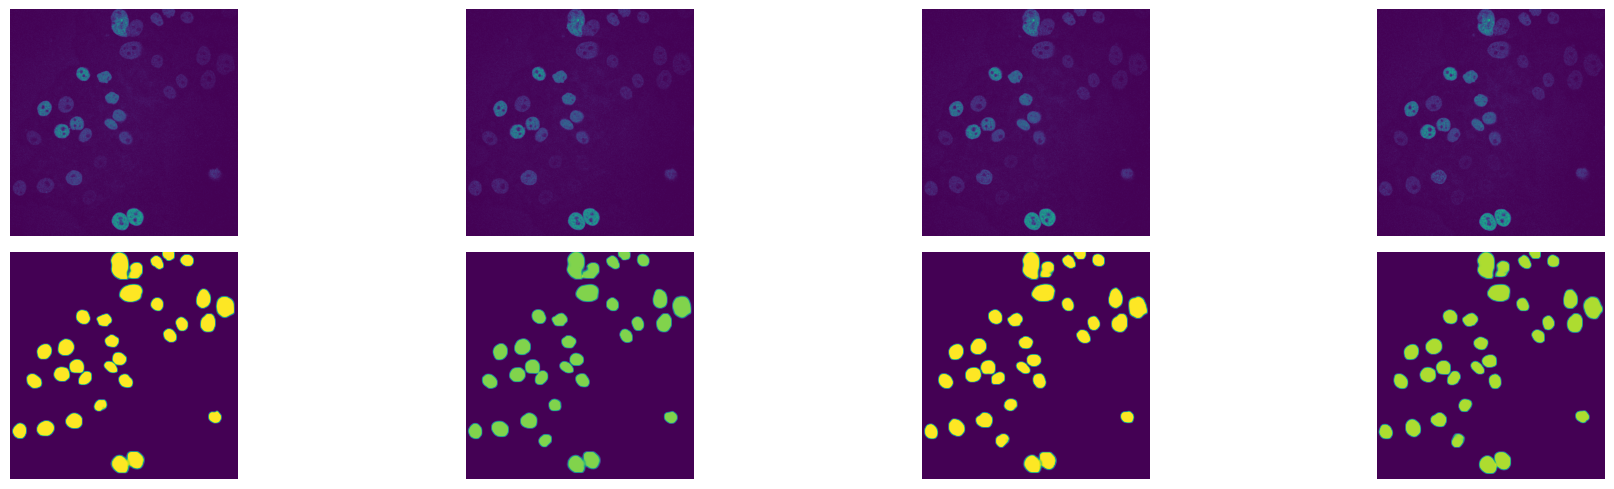

In [33]:
imgs_test = next(iter(test_loader))
batch = [img.to(DEVICE) for img in imgs_test]
MODEL.eval()
preds = np.zeros((BATCH_SIZE, 1, 1024, 1024))
with torch.no_grad():
    outs = MODEL(batch)

for i,out in enumerate(outs):
    mask = torch.sum(out['masks'], (0,1))
    print(np.unique(out['masks'].cpu()))
    preds[i] = mask.cpu()

plot_mini_batch(imgs_test[:,0,:,:].cpu(), preds[:,0,:,:], False, 4)

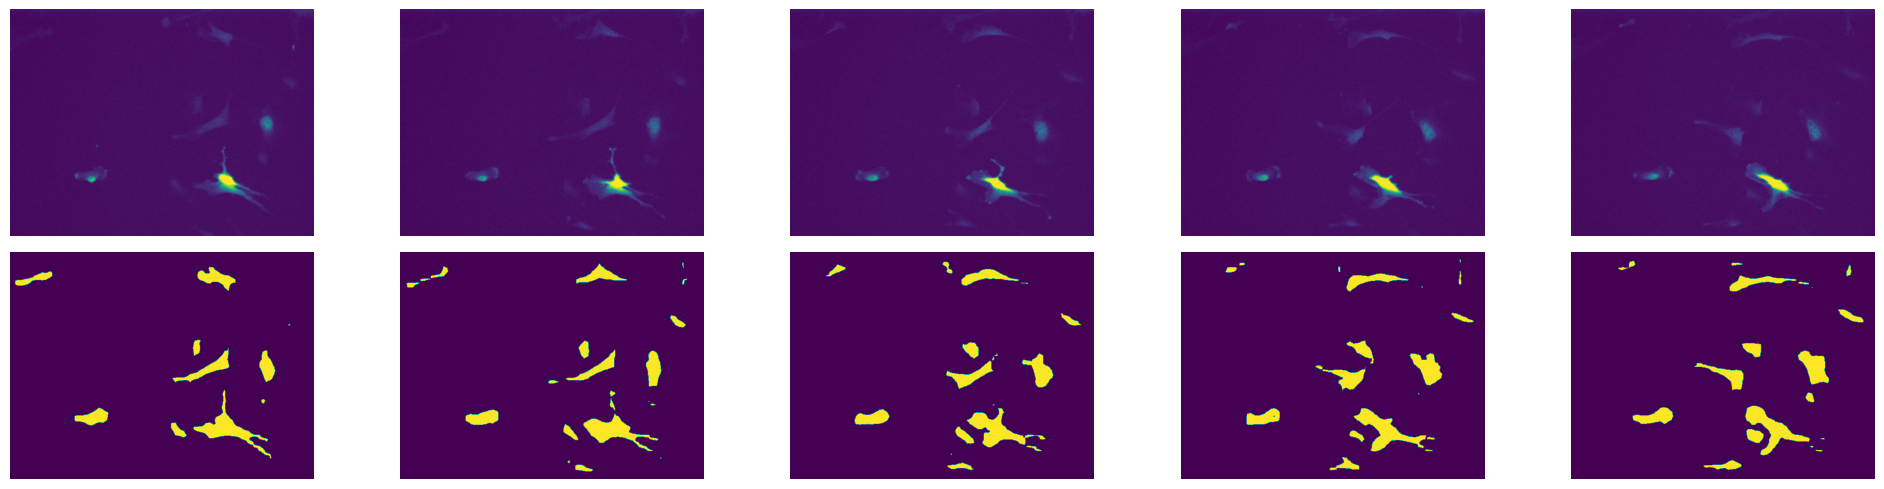

In [7]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(DEVICE, dtype=torch.float32)
MODEL.eval()
with torch.no_grad():
    scores = MODEL(imgs_test)['out']
    preds = torch.argmax(scores, dim=1).float()

plot_mini_batch(imgs_test.squeeze(1).cpu(), preds.cpu(), False, 5)